In [40]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

## Session, role and S3 Bucket

In [13]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

## Data

In [14]:
"""
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c534768_creditcardfraud/creditcardfraud.zip
!unzip creditcardfraud
"""

'\n!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c534768_creditcardfraud/creditcardfraud.zip\n!unzip creditcardfraud\n'

In [15]:
# read in the csv file
local_data = 'creditcard.csv'

# print out some data
transaction_df = pd.read_csv(local_data)
print('Data shape (rows, cols): ', transaction_df.shape)
print()
transaction_df.head()

Data shape (rows, cols):  (284807, 31)



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

In [16]:
# Calculate the fraction of data points that are fraudulent
def fraudulent_percentage(transaction_df):
    '''Calculate the fraction of all data points that have a 'Class' label of 1; fraudulent.
       :param transaction_df: Dataframe of all transaction data points; has a column 'Class'
       :return: A fractional percentage of fraudulent data points/all points
    '''
    # counts for all classes
    counts = transaction_df['Class'].value_counts()
    
    # get fraudulent and valid cnts
    fraud_cnts = counts[1]
    valid_cnts = counts[0]
    
    # calculate percentage of fraudulent data
    fraud_percentage = fraud_cnts/(fraud_cnts+valid_cnts)
    
    return fraud_percentage

In [17]:
# call the function to calculate the fraud percentage
fraud_percentage = fraudulent_percentage(transaction_df)

print('Fraudulent percentage = ', fraud_percentage)
print('Total # of fraudulent pts: ', fraud_percentage*transaction_df.shape[0])
print('Out of (total) pts: ', transaction_df.shape[0])


Fraudulent percentage =  0.001727485630620034
Total # of fraudulent pts:  492.0
Out of (total) pts:  284807


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

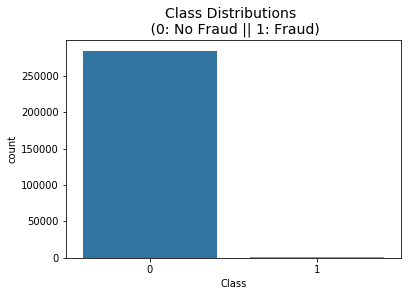

In [43]:
sns.countplot('Class', data=transaction_df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



(0.0, 172792.0)

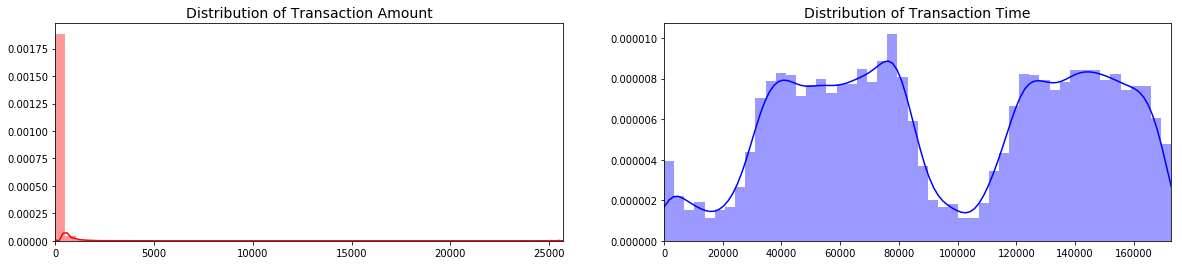

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20,4))

amount_val = transaction_df['Amount'].values
time_val = transaction_df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

## Splitting data into train and test

In [18]:
# split into train/test
def train_test_split(transaction_df, train_frac= 0.7, seed=1):
    '''Shuffle the data and randomly split into train and test sets;
       separate the class labels (the column in transaction_df) from the features.
       :param df: Dataframe of all credit card transaction data
       :param train_frac: The decimal fraction of data that should be training data
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    
    # convert the df into a matrix for ease of splitting
    df_matrix = transaction_df.as_matrix()
    
    # shuffle the data
    np.random.seed(seed)
    np.random.shuffle(df_matrix)
    
    # split the data
    train_size = int(df_matrix.shape[0] * train_frac)
    # features are all but last column
    train_features  = df_matrix[:train_size, :-1]
    # class labels *are* last column
    train_labels = df_matrix[:train_size, -1]
    # test data
    test_features = df_matrix[train_size:, :-1]
    test_labels = df_matrix[train_size:, -1]
    
    return (train_features, train_labels), (test_features, test_labels)


In [19]:
# get train/test data
(train_features, train_labels), (test_features, test_labels) = train_test_split(transaction_df, train_frac=0.7)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [20]:
# for a split of 0.7:0.3 there should be ~2.33x as many training as test pts
print('Training data pts: ', len(train_features))
print('Test data pts: ', len(test_features))
print()

Training data pts:  199364
Test data pts:  85443



# Modelling 

In [21]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'creditcard'
output_path = 's3://{}/{}'.format(bucket, prefix)

# include params for tuning for higher precision
# *and* account for class imbalance in training data
linear_precision = LinearLearner(role=role,
                                train_instance_count=1, 
                                train_instance_type='ml.c4.xlarge',
                                predictor_type='binary_classifier',
                                output_path=output_path,
                                sagemaker_session=sagemaker_session,
                                epochs=15,
                                binary_classifier_model_selection_criteria='recall_at_target_precision',
                                target_precision=0.9,
                                positive_example_weight_mult='balanced')


In [23]:
# convert features/labels to numpy
train_x_np = train_features.astype('float32')
train_y_np = train_labels.astype('float32')

# create RecordSet
formatted_train_data = linear_precision.record_set(train_x_np, labels=train_y_np)

In [24]:
%%time 

# train the estimator on formatted training data
linear_precision.fit(formatted_train_data)

2020-05-03 14:37:39 Starting - Starting the training job...
2020-05-03 14:37:40 Starting - Launching requested ML instances...
2020-05-03 14:38:36 Starting - Preparing the instances for training......
2020-05-03 14:39:16 Downloading - Downloading input data...
2020-05-03 14:39:55 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/03/2020 14:40:16 INFO 140218692695872] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_

## Deploy

In [25]:
%%time 
# deploy and evaluate a predictor
precision_predictor = linear_precision.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!CPU times: user 235 ms, sys: 9.65 ms, total: 245 ms
Wall time: 6min 31s


## Evaluation

In [26]:
# test one prediction
test_x_np = test_features.astype('float32')
result = precision_predictor.predict(test_x_np[0])

print(result)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.6123455762863159
    }
  }
}
]


In [27]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


In [28]:
print('Metrics for tuned (recall), LinearLearner.\n')

# get metrics for tuned predictor
metrics = evaluate(precision_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

Metrics for tuned (recall), LinearLearner.

prediction (col)    0.0  1.0
actual (row)                
0.0               85276   26
1.0                  31  110

Recall:     0.780
Precision:  0.809
Accuracy:   0.999



In [29]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [30]:
# delete the predictor endpoint 
delete_endpoint(precision_predictor)

Deleted linear-learner-2020-05-03-14-37-39-310
